https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [125]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
# Function to parse date parts to dates
def parse(x):
	return dt.strptime(x, '%Y %m %d %H')

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [127]:
# Import data
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse).drop(columns=['No'])
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# View data frame
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


### EDA

In [128]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


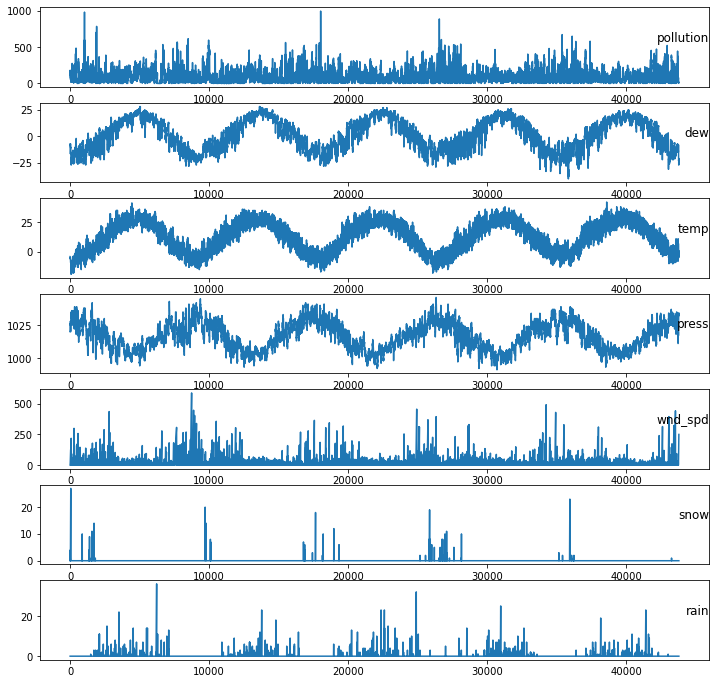

In [129]:
# Plottting
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=[12, 12])
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1

### Multivariate LSTM Forecast Model

#### LSTM data prep

In [130]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [131]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


#### Define model

In [132]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# train/test shapes
print('train_X shape: ',train_X.shape)
print('train_y shape: ',train_y.shape)
print('test_X shape: ',test_X.shape)
print('test_X shape: ',test_y.shape)

train_X shape:  (8760, 1, 8)
train_y shape:  (8760,)
test_X shape:  (35039, 1, 8)
test_X shape:  (35039,)


In [133]:
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [134]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [135]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [137]:
# fit network
history = model.fit(train_X, 
                    train_y, 
                    epochs=500, 
                    batch_size=72, 
                    #validation_data=(test_X, test_y),
                    validation_split=0.2, 
                    verbose=2, 
                    shuffle=False,
                    callbacks=[es, mc])

Epoch 1/500

Epoch 00001: val_loss improved from inf to 0.07543, saving model to best_model.h5
98/98 - 4s - loss: 0.0545 - val_loss: 0.0754 - 4s/epoch - 44ms/step
Epoch 2/500

Epoch 00002: val_loss improved from 0.07543 to 0.06476, saving model to best_model.h5
98/98 - 0s - loss: 0.0440 - val_loss: 0.0648 - 336ms/epoch - 3ms/step
Epoch 3/500

Epoch 00003: val_loss improved from 0.06476 to 0.04677, saving model to best_model.h5
98/98 - 0s - loss: 0.0346 - val_loss: 0.0468 - 328ms/epoch - 3ms/step
Epoch 4/500

Epoch 00004: val_loss improved from 0.04677 to 0.03715, saving model to best_model.h5
98/98 - 0s - loss: 0.0263 - val_loss: 0.0371 - 314ms/epoch - 3ms/step
Epoch 5/500

Epoch 00005: val_loss improved from 0.03715 to 0.02805, saving model to best_model.h5
98/98 - 0s - loss: 0.0228 - val_loss: 0.0280 - 334ms/epoch - 3ms/step
Epoch 6/500

Epoch 00006: val_loss improved from 0.02805 to 0.02430, saving model to best_model.h5
98/98 - 0s - loss: 0.0201 - val_loss: 0.0243 - 453ms/epoch - 5

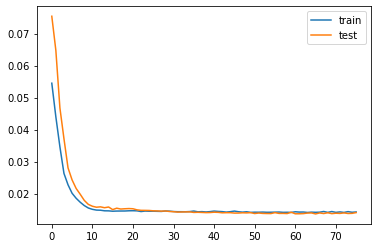

In [138]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

#### Evaluate model

In [139]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(inv_y, inv_yhat, squared=True)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 686.996


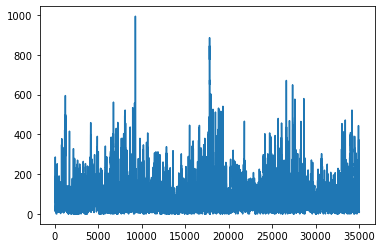

In [140]:
plt.plot(inv_y)

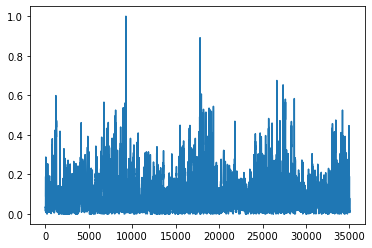

In [141]:
plt.plot(test_y)

In [142]:
print('Train X shape: ', train_X.shape)
print('Test X shape: ', test_X.shape)
print('Train y shape: ', inv_y.shape)
print('Test y shape: ', inv_yhat.shape)

Train X shape:  (8760, 1, 8)
Test X shape:  (35039, 8)
Train y shape:  (35039,)
Test y shape:  (35039,)


In [143]:
# load the saved model
saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(train_X, train_y, verbose=0)
_, test_acc = saved_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

TypeError: cannot unpack non-iterable float object

next: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/